# Libraries

In [1]:
import numpy as np 
import pandas as pd 
import tensorflow as tf 
import matplotlib.pyplot as plt 
import seaborn as sns
import re
import demoji
from tqdm import tqdm
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer

# Download necessary NLTK data
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\yeohz\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\yeohz\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\yeohz\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

# Data Preperation

#### Peek Data

In [34]:
df = pd.read_csv("../Dataset/Suicide_Detection.csv")
df

,Unnamed: 0,text,class
0,2,Ex Wife Threatening SuicideRecently I left my ...,suicide
1,3,Am I weird I don't get affected by compliments...,non-suicide
2,4,Finally 2020 is almost over... So I can never ...,non-suicide
3,8,i need helpjust help me im crying so hard,suicide
4,9,"I’m so lostHello, my name is Adam (16) and I’v...",suicide
...,...,...,...
232069,348103,If you don't like rock then your not going to ...,non-suicide
232070,348106,You how you can tell i have so many friends an...,non-suicide
232071,348107,pee probably tastes like salty tea😏💦‼️ can som...,non-suicide
232072,348108,The usual stuff you find hereI'm not posting t...,suicide


#### Check Null

In [36]:
df["text"].isnull().sum()

0

#### Class Balance

In [35]:
df["class"].value_counts()

suicide        116037
non-suicide    116037
Name: class, dtype: int64

Suicide and non-suicide text are equal in number.

#### Add space to some camel cased words

In [37]:
df['text'] = df['text'].replace(r"(\w)([A-Z])", r"\1 \2", regex=True)
df['text']

0         Ex Wife Threatening Suicide Recently I left my...
1         Am I weird I don't get affected by compliments...
2         Finally 2020 is almost over... So I can never ...
3                 i need helpjust help me im crying so hard
4         I’m so lost Hello, my name is Adam (16) and I’...
                                ...                        
232069    If you don't like rock then your not going to ...
232070    You how you can tell i have so many friends an...
232071    pee probably tastes like salty tea😏💦‼️ can som...
232072    The usual stuff you find here I'm not posting ...
232073    I still haven't beaten the first boss in Hollo...
Name: text, Length: 232074, dtype: object

#### Convert Emojis into Text

In [39]:
def emoji_to_text(text):
    return demoji.replace_with_desc(text, " ")

In [40]:
tqdm.pandas(desc="Progress Bar: ")
df["text"] = df["text"].progress_apply(emoji_to_text)

Progress Bar: 100%|███████████████████████████████████████████████████████████| 232074/232074 [22:55<00:00, 168.69it/s]


In [41]:
df["text"]

0         Ex Wife Threatening Suicide Recently I left my...
1         Am I weird I don't get affected by compliments...
2         Finally 2020 is almost over... So I can never ...
3                 i need helpjust help me im crying so hard
4         I’m so lost Hello, my name is Adam (16) and I’...
                                ...                        
232069    If you don't like rock then your not going to ...
232070    You how you can tell i have so many friends an...
232071    pee probably tastes like salty tea smirking fa...
232072    The usual stuff you find here I'm not posting ...
232073    I still haven't beaten the first boss in Hollo...
Name: text, Length: 232074, dtype: object

#### Lowercase alphabets

In [43]:
df["text"] = df["text"].str.lower()

In [44]:
df["text"]

0         ex wife threatening suicide recently i left my...
1         am i weird i don't get affected by compliments...
2         finally 2020 is almost over... so i can never ...
3                 i need helpjust help me im crying so hard
4         i’m so lost hello, my name is adam (16) and i’...
                                ...                        
232069    if you don't like rock then your not going to ...
232070    you how you can tell i have so many friends an...
232071    pee probably tastes like salty tea smirking fa...
232072    the usual stuff you find here i'm not posting ...
232073    i still haven't beaten the first boss in hollo...
Name: text, Length: 232074, dtype: object

#### Remove Stop Words

In [49]:
# Show incuded stop words
nltk.download('stopwords')
nltk.download('punkt')
stopwords = stopwords.words('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\yeohz\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\yeohz\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [50]:
stopwords

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [51]:
stopWordExceptions = ["but", "if", "because", "against",'no', 'nor','not', 'don', "don't", "ain", 
"aren't", 'aren',  'couldn',  "couldn't", 'didn', "didn't", "doesn't", 'hadn', "hadn't", 'hasn', "hasn't", 'haven',
"haven't", 'isn', "isn't", "mustn't", 'shan', "shan't", 'shouldn',"shouldn't", 'wasn', "wasn't",
'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't"]

In [52]:
print("Stop word exceptions: ", len(stopWordExceptions))
print("Stop words: ", len(stopwords))

Stop word exceptions:  38
Stop words:  179


In [53]:
customStopWords = [word for word in stopwords if word not in stopWordExceptions]
len(customStopWords)

141

In [54]:
def RemoveStopWords(text):
    word_tokens = word_tokenize(text)
    filtered_sentence = [word for word in word_tokens if word not in customStopWords]
    return filtered_sentence

In [55]:
df["text"] = df["text"].progress_apply(RemoveStopWords)

Progress Bar: 100%|███████████████████████████████████████████████████████████| 232074/232074 [04:12<00:00, 918.36it/s]


In [56]:
df["text"]

0         [ex, wife, threatening, suicide, recently, lef...
1         [weird, n't, get, affected, compliments, if, '...
2         [finally, 2020, almost, ..., never, hear, ``, ...
3                  [need, helpjust, help, im, crying, hard]
4         [’, lost, hello, ,, name, adam, (, 16, ), ’, s...
                                ...                        
232069    [if, n't, like, rock, not, going, get, anythin...
232070    [tell, many, friends, not, lonely, everything,...
232071    [pee, probably, tastes, like, salty, tea, smir...
232072    [usual, stuff, find, 'm, not, posting, sympath...
232073    [still, n't, beaten, first, boss, hollow, knig...
Name: text, Length: 232074, dtype: object

#### Remove Punctuations

In [59]:
def RemovePunctuations(text):
    cleaned_text = []
    for word in text:
        word = re.sub('[^\w\s!?]','', word)
        if word != "":
            cleaned_text.append(word)
    return cleaned_text

In [60]:
# Not alphabet o digit, remove
df["text"] = df['text'].apply(RemovePunctuations)

In [61]:
df["text"]

0         [ex, wife, threatening, suicide, recently, lef...
1         [weird, nt, get, affected, compliments, if, s,...
2         [finally, 2020, almost, never, hear, 2020, bad...
3                  [need, helpjust, help, im, crying, hard]
4         [lost, hello, name, adam, 16, struggling, year...
                                ...                        
232069    [if, nt, like, rock, not, going, get, anything...
232070    [tell, many, friends, not, lonely, everything,...
232071    [pee, probably, tastes, like, salty, tea, smir...
232072    [usual, stuff, find, m, not, posting, sympathy...
232073    [still, nt, beaten, first, boss, hollow, knigh...
Name: text, Length: 232074, dtype: object

In [151]:
df_temp = pd.read_csv("../Dataset/Suicide_Detection(After Remove Stop Words).csv")
df_temp

,text,class
0,ex wife threatening suicide recently left wife...,suicide
1,weird nt get affected compliments if s coming ...,non-suicide
2,finally 2020 almost never hear 2020 bad year e...,non-suicide
3,need helpjust help im crying hard,suicide
4,lost hello name adam 16 struggling years afrai...,suicide
...,...,...
232069,if nt like rock not going get anything but go ...,non-suicide
232070,tell many friends not lonely everything depriv...,non-suicide
232071,pee probably tastes like salty tea smirking fa...,non-suicide
232072,usual stuff find m not posting sympathy pity b...,suicide


In [152]:
# Drop nan values due to remove stop words; 18 records
df_temp = df_temp.dropna(axis=0)

In [154]:
df_temp

,text,class
0,ex wife threatening suicide recently left wife...,suicide
1,weird nt get affected compliments if s coming ...,non-suicide
2,finally 2020 almost never hear 2020 bad year e...,non-suicide
3,need helpjust help im crying hard,suicide
4,lost hello name adam 16 struggling years afrai...,suicide
...,...,...
232069,if nt like rock not going get anything but go ...,non-suicide
232070,tell many friends not lonely everything depriv...,non-suicide
232071,pee probably tastes like salty tea smirking fa...,non-suicide
232072,usual stuff find m not posting sympathy pity b...,suicide


In [155]:
df_temp.to_csv("../Dataset/Suicide_Detection(After Remove Stop Words nan removed).csv", index=False)

In [157]:
df = df_temp

In [159]:
df = df_temp.copy()

#### Lemmatization

In [160]:
# Initialize the WordNetLemmatizer
wnl = WordNetLemmatizer()

# Function to map NLTK POS tags to WordNet POS tags
def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN  # Default to noun


# Function to lemmatize a text
def lemmatize_text(text):
    # Tokenize the text
    tokens = nltk.word_tokenize(text)
    # POS tagging
    tagged_words = nltk.pos_tag(tokens)
    # Lemmatize each word with POS tag
    lemmatized_words = [wnl.lemmatize(word, pos=get_wordnet_pos(tag)) for word, tag in tagged_words]
    # Join lemmatized words into a single string
    lemmatized_text = ' '.join(lemmatized_words)
    return lemmatized_text

# # Ensure all entries in the 'text' column are strings
# df["text"] = df["text"].apply(lambda x: ' '.join(x) if isinstance(x, list) else str(x))

# Apply the lemmatization to the 'text' column
df['text'] = df['text'].apply(lemmatize_text)

# Print the DataFrame to see the results
print(df['text'])

0         ex wife threaten suicide recently leave wife g...
1         weird nt get affect compliment if s come someo...
2         finally 2020 almost never hear 2020 bad year e...
3                            need helpjust help im cry hard
4         lose hello name adam 16 struggle year afraid p...
                                ...                        
232069    if nt like rock not go get anything but go htt...
232070    tell many friend not lonely everything deprive...
232071    pee probably taste like salty tea smirk face s...
232072    usual stuff find m not post sympathy pity beca...
232073    still nt beat first bos hollow knight ve fough...
Name: text, Length: 232056, dtype: object


In [167]:
df.to_csv("../Dataset/Suicide_Detection(After Lemmitization).csv", index=False)

In [168]:
df_temp = pd.read_csv("../Dataset/Suicide_Detection(After Lemmitization).csv")
df_temp.isnull().any()

text     False
class    False
dtype: bool

In [169]:
df_temp

,text,class
0,ex wife threaten suicide recently leave wife g...,suicide
1,weird nt get affect compliment if s come someo...,non-suicide
2,finally 2020 almost never hear 2020 bad year e...,non-suicide
3,need helpjust help im cry hard,suicide
4,lose hello name adam 16 struggle year afraid p...,suicide
...,...,...
232051,if nt like rock not go get anything but go htt...,non-suicide
232052,tell many friend not lonely everything deprive...,non-suicide
232053,pee probably taste like salty tea smirk face s...,non-suicide
232054,usual stuff find m not post sympathy pity beca...,suicide


#### Word Embedding

In [6]:
df = df_naive_bayes.copy()

In [9]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('paraphrase-MiniLM-L6-v2')

embeddings = model.encode(df['text'].tolist())

df['embeddings'] = embeddings.tolist()

In [14]:
df.to_csv('../Dataset/Suicide_Detection(After Embeddings).csv', index=False)

# Models & Evaluation

In [45]:
from sklearn.model_selection import train_test_split
import pickle 

## Naive Bayes

### Preprocessing

In [3]:
from sklearn.feature_extraction.text import CountVectorizer

In [4]:
df_naive_bayes =  pd.read_csv("../Dataset/Suicide_Detection(After Lemmitization).csv")

In [5]:
df_naive_bayes["text"].isnull().sum()

0

In [6]:
df_naive_bayes["text"].to_numpy()

array(['ex wife threaten suicide recently leave wife good because cheat twice lie much decide refuse go back day ago begin threaten suicide tirelessly spent paat day talk keep hesitate because want believe ll come back know lot people threaten order get way but happen if really ? suppose handle death hand ? still love wife but not deal get cheat constantly feeling insecure m worry today may day hope much nt happen',
       'weird nt get affect compliment if s come someone know irl but feel really good internet stranger',
       'finally 2020 almost never hear 2020 bad year ever swear fuck god s annoy',
       ...,
       'pee probably taste like salty tea smirk face sweat droplet double exclamation mark someone drink pee confirm face roll eye double exclamation mark',
       'usual stuff find m not post sympathy pity because know far bad situation mine but want get stuff but seem life no point everything do life ruin quit isolate everyone even family not even like tell family would hel

### Label Encoder (class/y)

In [12]:
# Encode sentiment labels
from sklearn.preprocessing import LabelEncoder
labels = df_naive_bayes["class"].values
encoder = LabelEncoder()
encoded_labels = encoder.fit_transform(labels)

In [52]:
print(encoded_labels)
print("No. of Records: ", len(encoded_labels))

[1 0 0 ... 0 1 0]
No. of Records:  232056


### Split Data

Split data into Train, Val, Test: 70%, 15%, 15%.

In [53]:
# Split into train, remain, with stratify to maintain class proportion for each set
x_train, x_remain, y_train, y_remain = train_test_split(df_naive_bayes["text"], encoded_labels, stratify = encoded_labels, 
                                                    train_size=0.7, random_state=88)
print("x_train shape: ", x_train.shape)
print("x_remain shape: ", x_remain.shape)
print("y_train shape: ", y_train.shape)
print("y_remain shape: ", y_remain.shape)

x_train shape:  (162439,)
x_remain shape:  (69617,)
y_train shape:  (162439,)
y_remain shape:  (69617,)


In [59]:
# Split into val, test
x_val, x_test, y_val, y_test = train_test_split(x_remain, y_remain, stratify = y_remain, 
                                                    train_size=0.5, random_state=88)
print("x_val shape: ", x_val.shape)
print("x_test shape: ", x_test.shape)
print("y_val shape: ", y_val.shape)
print("y_test shape: ", y_test.shape)

x_val shape:  (34808,)
x_test shape:  (34809,)
y_val shape:  (34808,)
y_test shape:  (34809,)


### Count Vectorizer (text/x)

In [54]:
# Fit on Train data ONLY (Prevent data leakage to val and test sets)
vectorizer = CountVectorizer(max_features=3000)
vectorizer.fit(x_train)

print("Vocabulary Count: ", len(vectorizer.vocabulary_))

Vocabulary Count:  3000


In [67]:
# Transform x train
x_train_transformed = vectorizer.transform(x_train)
# Transform x val
x_val_transformed = vectorizer.transform(x_val)
# Transform x test
x_test_transformed = vectorizer.transform(x_test)

In [70]:
print("x train transformed shape: ", x_train_transformed.toarray().shape)
print("x val transformed shape: ", x_val_transformed.toarray().shape)
print("x test transformed shape: ", x_test_transformed.toarray().shape)

x train transformed shape:  (162439, 3000)
x val transformed shape:  (34808, 3000)
x test transformed shape:  (34809, 3000)


In [71]:
# transfrom x datasets to array type
x_train_transformed = x_train_transformed.toarray()
x_val_transformed = x_val_transformed.toarray()
x_test_transformed = x_test_transformed.toarray()

In [63]:
# Ensure transformation worked
for i in x_train_transformed[5]:
    if i == 1:
        print("ok")
        break

ok


In [64]:
len(vectorizer.vocabulary_)

3000

In [66]:
vectorizer.vocabulary_

{'need': 1762,
 'help': 1256,
 'get': 1139,
 'depressed': 717,
 'thinking': 2671,
 'past': 1914,
 'wife': 2924,
 'meet': 1653,
 'high': 1265,
 'school': 2292,
 'sophomore': 2465,
 'year': 2981,
 'great': 1179,
 'senior': 2323,
 'break': 388,
 'because': 304,
 'want': 2876,
 'hang': 1216,
 'friend': 1097,
 'felt': 1014,
 'like': 1536,
 'start': 2512,
 'talk': 2614,
 'little': 1548,
 'but': 424,
 'stage': 2506,
 'would': 2958,
 'go': 1150,
 'guy': 1202,
 'make': 1601,
 'jealous': 1444,
 'told': 2710,
 'later': 1495,
 'back': 270,
 'together': 2707,
 'could': 609,
 'commit': 543,
 'relationship': 2179,
 'fast': 996,
 'forward': 1079,
 'seven': 2339,
 'present': 2040,
 'marry': 1617,
 'old': 1846,
 'time': 2698,
 'tell': 2637,
 'sleep': 2420,
 'mine': 1684,
 'shock': 2366,
 'ca': 430,
 'nt': 1811,
 'stop': 2530,
 'picture': 1962,
 'mind': 1682,
 'image': 1355,
 'two': 2775,
 'sex': 2343,
 'since': 2400,
 'date': 682,
 'young': 2989,
 'never': 1774,
 'really': 2148,
 'anyone': 184,
 'else':

### Base Model

In [79]:
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay

In [78]:
multi_NB_base_model = MultinomialNB()
multi_NB_base_model.fit(x_train_transformed, y_train)
y_pred_base_model = multi_NB_base_model.predict(x_val_transformed)

Multinomial Accuracy: 0.860405653872673

The classification report with metrics: 

               precision    recall  f1-score   support

           0       0.95      0.76      0.84     17403
           1       0.80      0.96      0.87     17405

    accuracy                           0.86     34808
   macro avg       0.88      0.86      0.86     34808
weighted avg       0.88      0.86      0.86     34808



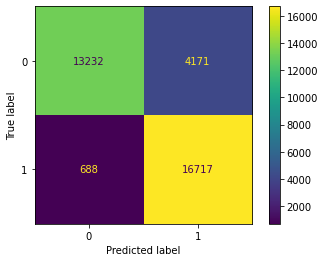

In [83]:
# Results
print("Multinomial Accuracy:", accuracy_score(y_val, y_pred_base_model))
print("\nThe classification report with metrics: \n\n", classification_report(y_val, y_pred_base_model))
cm = confusion_matrix(y_val, y_pred_base_model)
display = ConfusionMatrixDisplay(confusion_matrix=cm)
display.plot()

---------- Ensure predictor is working ----------

Prediction is accurate for these three records by human evaluation.

In [92]:
y_pred_base_model

array([1, 0, 1, ..., 1, 1, 1])

In [93]:
x_val

189704    like prepare future right no serious think sui...
85943     2007 call bitch do ? see miss step bad luck ra...
158847    m ready give life one disappointment another f...
13769     good fashionable store buy clothes love point ...
224794    future career goal ? filler filler filler fill...
                                ...                        
166920                       do m fuck bleed like crazy wow
146894    want live like legend without monster thing m ...
162623    another night alone honestly want kill m sick ...
92625     think know definition pain ? think pimple schlong
19459     suicide hotline hour ? look suicide hotlines c...
Name: text, Length: 34808, dtype: object

In [94]:
x_val[189704]

'like prepare future right no serious think suicide doubt serious think close future either but fear age death almost every day scar day beyond chance make life well best good day behind living regret what if think till fade away hospital bed piss shit pant fuck no not want live long want prepare think end life term way want go place want incredibly afraid life end not live today fuck wrong think ? give actual comfort know way if everything turn bad'

In [95]:
x_val[85943]

'2007 call bitch do ? see miss step bad luck random chance wait parent kick ?'

In [96]:
x_val[158847]

'm ready give life one disappointment another father leave little nt see since apparently real loser anyway mentor abuse almost three year leave real fucked mom yell ignore go way not touch think hate get anxious time never serious girlfriend old sister graduate no longer go live home get horrible grade school last year nt believe god anymore mean point throw towel say enough enough get one life earth u get dealt real shitty hand prolong ? s point living worthless life ? m not immediate risk right but s like even matter ? anyone even care ?'

---------- Ensure predictor is working END ----------